# Comparisons with Baseline Methods

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
import torch
import botorch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

In [3]:
dtype  = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
np.random.seed(12345)

###  Variational Autoencoder (VAE)

In [5]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device

        # Define layers but do not use them directly in forward pass
        self.encoder_lin1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        self.decoder_lin1 = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lin2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # Using the functional interface with cloned weights and biases
        x = F.linear(x, self.encoder_lin1.weight.clone(), self.encoder_lin1.bias)
        x = F.leaky_relu(x)
        x = F.linear(x, self.encoder_lin2.weight.clone(), self.encoder_lin2.bias)
        # x = F.leaky_relu(x)  # Uncomment if needed
        mean = F.linear(x, self.mean_layer.weight.clone(), self.mean_layer.bias)
        logvar = F.linear(x, self.logvar_layer.weight.clone(), self.logvar_layer.bias)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(self.device)
        z = mean + torch.exp(0.5 * logvar) * epsilon
        return z

    def decode(self, z):
        z = F.linear(z, self.decoder_lin1.weight.clone(), self.decoder_lin1.bias)
        z = F.leaky_relu(z)
        z = F.linear(z, self.decoder_lin2.weight.clone(), self.decoder_lin2.bias)
        # z = torch.sigmoid(z)  # Uncomment if needed
        return z

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

### Evidence Lower Bound

In [6]:
def loss_function(x_hat, x, mean, log_var, beta=0.5):
    # reconstruction loss
    reconstruction_loss = ((x - x_hat)**2).sum()

    # KL divergence
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    # total
    total_loss = reconstruction_loss + beta*kl_divergence
    return reconstruction_loss, kl_divergence, total_loss

In [7]:
def train_vae(vae, data, num_epochs, batch_size, lr, beta):
    optimizer  = torch.optim.Adam(vae.parameters(), lr=lr)
    mse_list   = []
    kl_list    = []
    total_list = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        mse_loss   = 0.0
        kl_loss    = 0.0

        for batch_start in range(0, len(data), batch_size):
            batch = data[batch_start:batch_start + batch_size].to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = vae(batch)
            mse, kl, total = loss_function(x_hat, batch, mean, log_var, beta)
            total.backward(retain_graph=True)
            optimizer.step()

            total_loss += total.item()
            mse_loss   += mse.item()
            kl_loss    += kl.item()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data):.4f}, MSE: {mse_loss/len(data):.4f}')
            
        mse_list.append((mse_loss/len(data)))
        kl_list.append((kl_loss/len(data)))
        total_list.append(total_loss/len(data))

    return mse_list, kl_list, total_list

### Conditional Variational Autoencoder (CVAE)

In [8]:
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, condition_dim, device=device):
        super(CVAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.condition_dim = condition_dim
        self.device = device

        # Adjust input dimensions for encoder to include condition
        adjusted_input_dim = input_dim + condition_dim
        # Adjust input dimensions for decoder to include condition
        adjusted_latent_dim = latent_dim + condition_dim

        # Define layers with adjusted dimensions
        self.encoder_lin1 = nn.Linear(adjusted_input_dim, hidden_dim)
        self.encoder_lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        self.decoder_lin1 = nn.Linear(adjusted_latent_dim, hidden_dim)
        self.decoder_lin2 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, condition):
        # Concatenate the condition with the input
        x = torch.cat((x, condition.to(self.device)), dim=1)
        x = F.linear(x, self.encoder_lin1.weight.clone(), self.encoder_lin1.bias)
        x = F.leaky_relu(x)
        x = F.linear(x, self.encoder_lin2.weight.clone(), self.encoder_lin2.bias)
        mean = F.linear(x, self.mean_layer.weight.clone(), self.mean_layer.bias)
        logvar = F.linear(x, self.logvar_layer.weight.clone(), self.logvar_layer.bias)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(self.device)
        z = mean + torch.exp(0.5 * logvar) * epsilon
        return z

    def decode(self, z, condition):
        # Concatenate the condition with the latent vector
        z = torch.cat((z, condition.to(self.device)), dim=1)
        z = F.linear(z, self.decoder_lin1.weight.clone(), self.decoder_lin1.bias)
        z = F.leaky_relu(z)
        z = F.linear(z, self.decoder_lin2.weight.clone(), self.decoder_lin2.bias)
        return z

    def forward(self, x, condition):
        mean, log_var = self.encode(x, condition)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z, condition)
        return x_hat, mean, log_var


In [9]:
def train_cvae(cvae, data, conditions, num_epochs, batch_size, lr, beta, vis_epoch_gap = 10):
    optimizer  = torch.optim.Adam(cvae.parameters(), lr=lr)
    mse_list   = []
    kl_list    = []
    total_list = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        mse_loss   = 0.0
        kl_loss    = 0.0

        for batch_start in range(0, len(data), batch_size):
            batch, batch_conditions = data[batch_start:batch_start + batch_size].to(device), conditions[batch_start:batch_start + batch_size].to(device)

            optimizer.zero_grad()
            x_hat, mean, log_var = cvae(batch, batch_conditions)
            mse, kl, total = loss_function(x_hat, batch, mean, log_var, beta)
            total.backward(retain_graph=True)
            optimizer.step()

            total_loss += total.item()
            mse_loss   += mse.item()
            kl_loss    += kl.item()

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data):.4f}, MSE: {mse_loss/len(data):.4f}')
            
        mse_list.append((mse_loss/len(data)))
        kl_list.append((kl_loss/len(data)))
        total_list.append(total_loss/len(data))

    return mse_list, kl_list, total_list

## CageBO

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from tqdm.notebook import tqdm
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')

In [11]:
class CageBO():
    def __init__(self, data, obj_func, autoencoder, n_initial=10):
        self.data        = data               # [num_samples, dim]
        self.obj_func    = obj_func           # objective function
        self.autoencoder = autoencoder        # cvae
        self.input_dim   = self.data.shape[1]

        self.best_objs   = []                 # where best objective values will be stored
        self.best_xs     = []                 # where X values for corresponding best objective values will be stored

        ##### Step 1: Randomly select I solutions X_0 and evaluate f(X_0) #####
        random_indices = torch.randperm(data.size(0))[:n_initial]
        X0 = data[random_indices] # [n_initial, dim]
        self.Xt = X0

        Y0 = obj_func(X0)
        self.best_obj = min(Y0) # set initial min(Y)
        self.best_objs.append(self.best_obj)

        print('Initial Best Objective Value:', self.best_obj)
        self.Yt = Y0
        self.best_x = self.Xt[torch.argmin(self.Yt)]
        self.best_xs.append(self.best_x)

        ##### Step 2: Encode latent variables #####
        Z0 = self.autoencoder.encode(X0, torch.ones(n_initial, 1))[0]
        self.Zt = Z0

        # initialize GP
        self.gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), # DotProduct
                                    alpha=1e-8,
                                    normalize_y=True,
                                    n_restarts_optimizer=5,
                                    random_state=12345)


    def lower_confidence_bound(self, Zt, beta=1):
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        return mean-beta*std


    def expected_improvement(self, Zt):
        """
        measures the expected improvement of choose z as the next candidate latent variable
        over the best achieved objective function value ymin = min(Y)
        """
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        z = (self.best_obj.cpu().detach().numpy() - mean)/(std + 1e-9)
        return ((self.best_obj.cpu().detach().numpy() - mean) * norm.cdf(z) + std * norm.pdf(z))[0]

    def suggest_candidate(self, l_dim, lcb, n_suggest):
        """
        sample K (n_suggest) indep. latent variable Zhat from N(0,I)
        and select the one with the largest EI
        to be decoded and evaluated by the objective function f
        """
        best = 0
        zt = np.random.normal(size=l_dim)

        if lcb:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            lcb = self.lower_confidence_bound(Zhat)
            if lcb < best:
                best = lcb
                zt = Zhat

        else:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            ei = self.expected_improvement(Zhat)
            if ei > best:
                best = ei
                zt = Zhat

        return zt


    def post_process(self, xhat, xt):
        """
        PD(xhat) = argmin_{x \in D} ||x-xhat||_2
        """
        norms = torch.norm(xt - xhat, dim=1)
        closest_idx = torch.argmin(norms)
        best_xt = xt[closest_idx]
        return best_xt


    ##### Step 3: Main Loop #####
    def run(self, l_dim, n_suggest, n_iter, lcb):
      for i in tqdm(range(n_iter)):
          if i % 10 == 0:
            print('iter', i, ' best fX:', self.best_obj)
          with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                ##### Substep 1: train GP with (Z_{t-1}, Y_{t-1}) #####
                z_np_list = [zt.cpu().detach().numpy() for zt in self.Zt]
                y_np_list = [yt.cpu().detach().numpy() for yt in self.Yt]

                self.gp.fit(np.vstack(z_np_list), np.hstack(y_np_list))

                ##### Substep 2: suggest candidate latent variable #####
                zt = self.suggest_candidate(l_dim, lcb, n_suggest)
                zt = torch.tensor(zt, dtype=torch.float32, device=device)

                ##### Substep 3: decode and post-decode #####
                xhatt = self.autoencoder.decode(torch.tensor(zt, dtype=torch.float).reshape((1,-1)), torch.ones(1,1))
                xt = self.post_process(xhatt, self.data)

                ##### Substep 4: Update Xt, Zt, Yt #####
                self.Xt = torch.cat((self.Xt, xt.view(1,-1)), dim=0)
                yt = torch.tensor([self.obj_func(xt.unsqueeze(0))], device=device)

                self.Yt = torch.cat((self.Yt, yt), dim=0)
                self.Zt = torch.cat((self.Zt, zt.view(1,-1)), dim=0)

                if min(self.Yt) < self.best_obj:
                  self.best_obj = min(self.Yt)

                self.best_objs.append(self.best_obj)
                self.best_x = self.Xt[torch.argmin(self.Yt)]
                self.best_xs.append(self.best_x)

      return self.best_objs, self.best_xs

## Naive BO

In [12]:
class naive_BO():
    def __init__(self, data, obj_func, n_initial):
        self.data        = data               # [num_samples, dim]
        self.obj_func    = obj_func           # objective function
        self.input_dim   = self.data.shape[1]

        self.best_objs   = []                 # where best objective values will be stored
        self.best_xs     = []                 # where X values for corresponding best objective values will be stored

        ##### Step 1: Randomly select I solutions X_0 and evaluate f(X_0) #####
        random_indices = torch.randperm(data.size(0))[:n_initial]
        X0 = data[random_indices] # [n_initial, dim]
        self.Xt = X0

        Y0 = obj_func(X0)
        self.best_obj = min(Y0) # set initial min(Y)
        self.best_objs.append(self.best_obj)

        print('Initial Best Objective Value:', self.best_obj)
        self.Yt = Y0
        self.best_x = self.Xt[torch.argmin(self.Yt)]
        self.best_xs.append(self.best_x)

        # initialize GP
        self.gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), # DotProduct
                                    alpha=1e-8,
                                    normalize_y=True,
                                    n_restarts_optimizer=5,
                                    random_state=12345)


    def lower_confidence_bound(self, Zt, beta=1):
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        return mean-beta*std


    def expected_improvement(self, Zt):
        """
        measures the expected improvement of choose z as the next candidate latent variable
        over the best achieved objective function value ymin = min(Y)
        """
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        z = (self.best_obj.cpu().detach().numpy() - mean)/(std + 1e-9)
        return ((self.best_obj.cpu().detach().numpy() - mean) * norm.cdf(z) + std * norm.pdf(z))[0]


    def suggest_candidate(self, l_dim, lcb, n_suggest):
        """
        sample K (n_suggest) indep. latent variable Zhat from N(0,I)
        and select the one with the largest EI
        to be decoded and evaluated by the objective function f
        """
        best = 0
        zt = np.random.normal(size=l_dim)

        if lcb:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            lcb = self.lower_confidence_bound(Zhat)
            if lcb < best:
                best = lcb
                zt = Zhat

        else:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            ei = self.expected_improvement(Zhat)
            if ei > best:
                best = ei
                zt = Zhat

        return zt


    def post_process(self, xhat, xt):
        """
        PD(xhat) = argmin_{x \in D} ||x-xhat||_2
        """
        norms = torch.norm(xt - xhat, dim=1)
        closest_idx = torch.argmin(norms)
        best_xt = xt[closest_idx]
        return best_xt


    ##### Step 3: Main Loop #####
    def run(self, n_suggest, n_iter, lcb):
      for i in tqdm(range(n_iter)):
          if i % 10 == 0:
            print('iter', i, ' best fX:', self.best_obj)
          with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                ##### Substep 1: train GP with (X_{t-1}, Y_{t-1}) #####
                x_np_list = [xt.cpu().detach().numpy() for xt in self.Xt]
                y_np_list = [yt.cpu().detach().numpy() for yt in self.Yt]

                self.gp.fit(np.vstack(x_np_list), np.hstack(y_np_list))

                ##### Substep 2: suggest candidate in the original space #####
                new_candidate = self.suggest_candidate(self.input_dim, lcb, n_suggest)
                xhatt = torch.tensor(new_candidate, dtype=torch.float32, device=device)

                ##### Substep 3: post-decode #####
                xt = self.post_process(xhatt, self.data)

                ##### Substep 4. Update Xt, Yt #####
                self.Xt = torch.cat((self.Xt, xt.view(1,-1)), dim=0)

                yt = torch.tensor([self.obj_func(xt.unsqueeze_(0))], device=device)
                self.Yt = torch.cat((self.Yt, yt), dim=0)

                if min(self.Yt) < self.best_obj:
                  self.best_obj = min(self.Yt)

                self.best_objs.append(self.best_obj)
                self.best_x = self.Xt[torch.argmin(self.Yt)]
                self.best_xs.append(self.best_x)

      return self.best_objs, self.best_xs

##  Hidden Constraints Latent Space Bayesian Optimization

In [13]:
class LSBO():
    def __init__(self, data, obj_func, autoencoder, n_initial):
        self.data        = data               # [num_samples, dim]
        self.obj_func    = obj_func           # objective function
        self.autoencoder = autoencoder        # vae
        self.input_dim   = self.data.shape[1]

        self.best_objs   = []                 # where best objective values will be stored
        self.best_xs     = []                 # where X values for corresponding best objective values will be stored

        ##### Step 1: Randomly select I solutions X_0 and evaluate f(X_0) #####
        random_indices = torch.randperm(data.size(0))[:n_initial]
        X0 = data[random_indices] # [n_initial, dim]
        self.Xt = X0

        Y0 = obj_func(X0)
        self.best_obj = min(Y0) # set initial min(Y)
        self.best_objs.append(self.best_obj)

        print('Initial Best Objective Value:', self.best_obj)
        self.Yt = Y0
        self.best_x = self.Xt[torch.argmin(self.Yt)]
        self.best_xs.append(self.best_x)

        ##### Step 2: Encode latent variables #####
        Z0 = self.autoencoder.encode(X0)[0]
        self.Zt = Z0

        # initialize GP
        self.gp = GaussianProcessRegressor(kernel=Matern(nu=2.5), # DotProduct
                                    alpha=1e-8,
                                    normalize_y=True,
                                    n_restarts_optimizer=5,
                                    random_state=12345)


    def lower_confidence_bound(self, Zt, beta=1):
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        return mean-beta*std


    def expected_improvement(self, Zt):
        """
        measures the expected improvement of choose z as the next candidate latent variable
        over the best achieved objective function value ymin = min(Y)
        """
        with warnings.catch_warnings():
             warnings.simplefilter("ignore")
             mean, std = self.gp.predict(np.array(Zt).reshape(1, -1), return_std=True)

        z = (self.best_obj.cpu().detach().numpy() - mean)/(std + 1e-9)
        return ((self.best_obj.cpu().detach().numpy() - mean) * norm.cdf(z) + std * norm.pdf(z))[0]


    def suggest_candidate(self, l_dim, lcb, n_suggest):
        """
        sample K (n_suggest) indep. latent variable Zhat from N(0,I)
        and select the one with the largest EI
        to be decoded and evaluated by the objective function f
        """
        best = 0
        zt = np.random.normal(size=l_dim)

        if lcb:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            lcb = self.lower_confidence_bound(Zhat)
            if lcb < best:
                best = lcb
                zt = Zhat

        else:
          for i in range(n_suggest):
            Zhat = np.random.normal(size=l_dim)
            ei = self.expected_improvement(Zhat)
            zt_hat = torch.tensor(Zhat, dtype=torch.float32, device=device)
            xhatt = self.autoencoder.decode(zt_hat.reshape((1,-1)))
            xt, dist = self.post_process(xhatt, self.data)
            if ei/dist > best:
                best = ei/dist
                zt = Zhat

        return zt


    def post_process(self, xhat, xt):
        """
        PD(xhat) = argmin_{x \in D} ||x-xhat||_2
        """
        norms = torch.norm(xt - xhat, dim=1)
        closest_idx = torch.argmin(norms)
        best_xt = xt[closest_idx]
        return best_xt, norms[closest_idx]


    ##### Step 3: Main Loop #####
    def run(self, l_dim, n_suggest, n_iter, lcb):
      for i in tqdm(range(n_iter)):
          if i % 10 == 0:
            print('iter', i, ' best fX:', self.best_obj)
          with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                ##### Substep 1: train GP with (Z_{t-1}, Y_{t-1}) #####
                z_np_list = [zt.cpu().detach().numpy() for zt in self.Zt]
                y_np_list = [yt.cpu().detach().numpy() for yt in self.Yt]

                self.gp.fit(np.vstack(z_np_list), np.hstack(y_np_list))

                ##### Substep 2: suggest candidate latent variable #####
                zt = self.suggest_candidate(l_dim, lcb, n_suggest)
                zt = torch.tensor(zt, dtype=torch.float32, device=device)

                ##### Substep 3: decode and post-decode #####
                xhatt = self.autoencoder.decode(zt.reshape((1,-1)))
                xt, _ = self.post_process(xhatt, self.data)

                ##### Substep 4: Update Xt, Zt, Yt #####
                self.Xt = torch.cat((self.Xt, xt.view(1,-1)), dim=0)
                yt = torch.tensor([self.obj_func(xt.unsqueeze(0))], device=device)

                self.Yt = torch.cat((self.Yt, yt), dim=0)
                self.Zt = torch.cat((self.Zt, zt.view(1,-1)), dim=0)

                if min(self.Yt) < self.best_obj:
                  self.best_obj = min(self.Yt)

                self.best_objs.append(self.best_obj)
                self.best_x = self.Xt[torch.argmin(self.Yt)]
                self.best_xs.append(self.best_x)

      return self.best_objs, self.best_xs

## Simulated Annealing

In [14]:
import random

def simulated_annealing(obj_func, data, bounds, max_iter=1000, T0=1.0, T_min=1e-10, alpha=0.95, num_neighbors=5):

    state = data[torch.randint(1, data.shape[0], (1,))]
    current_energy = obj_func(state)
    print('current energy:', current_energy)
    best_state = state
    best_energy = torch.squeeze(current_energy)

    best_energies = []
    best_energies.append(best_energy)

    T = T0

    for _ in range(max_iter-1):
        distances = torch.norm(data - state, dim=1)

        nearest_neighbor_indices = torch.argsort(distances)

        nearby_indices = nearest_neighbor_indices[:num_neighbors]

        new_state_index = random.choice(nearby_indices)
        new_state = data[new_state_index]
        new_state = torch.clamp(new_state, bounds[0], bounds[1])

        new_energy = obj_func(torch.tensor(new_state))

        delta_energy = new_energy - current_energy

        if delta_energy < 0 or torch.rand(1, device=device) < torch.exp(torch.tensor(-delta_energy / T)):
            state = new_state
            current_energy = new_energy

        if current_energy < best_energy:
            best_state = state
            best_energy = current_energy

        T *= alpha
        if T < T_min:
            break

        best_energies.append(best_energy)

    return best_state, best_energies

### Test Function

In [15]:
from __future__ import annotations

from typing import List, Optional, Tuple

from botorch.test_functions.base import BaseTestProblem, ConstrainedBaseTestProblem
from botorch.test_functions.utils import round_nearest


class SyntheticTestFunction(BaseTestProblem):
    r"""Base class for synthetic test functions."""

    _optimal_value: float
    _optimizers: Optional[List[Tuple[float, ...]]] = None
    num_objectives: int = 1

    def __init__(
        self,
        noise_std: Optional[float] = None,
        negate: bool = False,
        bounds: Optional[List[Tuple[float, float]]] = None,
    ) -> None:
        r"""
        Args:
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the function.
            bounds: Custom bounds for the function specified as (lower, upper) pairs.
        """
        if bounds is not None:
            self._bounds = bounds
        super().__init__(noise_std=noise_std, negate=negate)
        if self._optimizers is not None:
            if bounds is not None:
                # Ensure at least one optimizer lies within the custom bounds
                def in_bounds(
                    optimizer: Tuple[float, ...], bounds: List[Tuple[float, float]]
                ) -> bool:
                    for i, xopt in enumerate(optimizer):
                        lower, upper = bounds[i]
                        if xopt < lower or xopt > upper:
                            return False

                    return True

                if not any(
                    in_bounds(optimizer=optimizer, bounds=bounds)
                    for optimizer in self._optimizers
                ):
                    raise ValueError(
                        "No global optimum found within custom bounds. Please specify "
                        "bounds which include at least one point in "
                        f"`{self.__class__.__name__}._optimizers`."
                    )
            self.register_buffer(
                "optimizers", torch.tensor(self._optimizers, dtype=torch.float)
            )

    @property
    def optimal_value(self) -> float:
        r"""The global minimum (maximum if negate=True) of the function."""
        return -self._optimal_value if self.negate else self._optimal_value

# High-Dimensional Functions

Ackley, Rosenbrock, Keane, DixonPrice, Griewank, Hartmann, Levy, Michalewicz, Powell, Rastrigin, Rosenbrock, StyblinskiTang

Parameters:
1.  n_initial = 5
2.  n_suggest = 1000
3.  batch_size = 50
4.  num_epochs = 1000
5.  n_iter = 200
6.  n_run = 100 (for UQ)

## 1) 30-d Keane Bump Function

In [16]:
class Keane_Bump(SyntheticTestFunction):
    def __init__(
        self,
        dim: int = 2,
        noise_std: Optional[float] = None,
        negate: bool = False,
        bounds: Optional[List[Tuple[float, float]]] = None,
    ) -> None:
        self.dim = dim
        if bounds is None:
            bounds = [(0, 10) for _ in range(self.dim)]
        super().__init__(noise_std=noise_std, negate=negate, bounds=bounds)

    def evaluate_true(self, X: Tensor) -> Tensor:
        i = torch.arange(1, X.shape[1] + 1).to(dtype=dtype, device=device)

        numerator = torch.cos(X).pow(4).sum(dim=1) - 2 * torch.cos(X).pow(2).prod(dim=1)
        denominator = torch.sqrt((i * X.pow(2)).sum(dim=1))

        val = -torch.abs(numerator / (denominator + 1e-9))

        return val

In [17]:
# hyperparameters
condit_dim  = 1
input_dim   = 30
hidden_dim  = 256
latent_dim  = 10
num_samples = 1000
num_epochs  = 1000 # for VAE training

batch_size  = 50

n_initial = 5
n_suggest = 10

n_run = 10

In [18]:
keane = Keane_Bump(dim=input_dim).to(dtype=dtype, device=device)

In [19]:
vae_keane = VAE(input_dim, hidden_dim, latent_dim).to(device)
cvae_keane = CVAE(input_dim, hidden_dim, latent_dim, condit_dim).to(device)

In [20]:
random_input = torch.rand((num_samples, latent_dim)).to(device)
random_decoded_data = vae_keane.decode(random_input)

min_values, _ = random_decoded_data.min(dim=0)
max_values, _ = random_decoded_data.max(dim=0)

scaling_factors = 10.0 / (max_values - min_values)

offset = -min_values * scaling_factors

scaled_data = random_decoded_data * scaling_factors + offset

### Training

In [21]:
vae_mse_list, vae_kl_list, vae_total_list = train_vae(vae_keane, scaled_data, num_epochs, batch_size, lr=1e-4, beta=0.09)

Epoch [100/1000], Loss: 18.3236, MSE: 12.6062
Epoch [200/1000], Loss: 13.6131, MSE: 9.4933
Epoch [300/1000], Loss: 12.9591, MSE: 9.3160
Epoch [400/1000], Loss: 12.5680, MSE: 8.9597
Epoch [500/1000], Loss: 12.6706, MSE: 9.0202
Epoch [600/1000], Loss: 12.7554, MSE: 9.0160
Epoch [700/1000], Loss: 12.5539, MSE: 8.7070
Epoch [800/1000], Loss: 12.6641, MSE: 8.7416
Epoch [900/1000], Loss: 12.3980, MSE: 8.3632
Epoch [1000/1000], Loss: 12.4410, MSE: 8.3196


In [22]:
cvae_mse_list, cvae_kl_list, cvae_total_list = train_cvae(cvae_keane, scaled_data, torch.ones(len(scaled_data), 1, device=device), 
                                                           num_epochs, batch_size, lr=1e-4, beta=0.09)

Epoch [100/1000], Loss: 13.3506, MSE: 7.6102
Epoch [200/1000], Loss: 9.4309, MSE: 5.7027
Epoch [300/1000], Loss: 7.8803, MSE: 4.6746
Epoch [400/1000], Loss: 7.0768, MSE: 4.1245
Epoch [500/1000], Loss: 6.5812, MSE: 3.7486
Epoch [600/1000], Loss: 6.0834, MSE: 3.3621
Epoch [700/1000], Loss: 5.5695, MSE: 2.9341
Epoch [800/1000], Loss: 5.0191, MSE: 2.4571
Epoch [900/1000], Loss: 4.5959, MSE: 2.0929
Epoch [1000/1000], Loss: 4.3233, MSE: 1.8448


### Evaluation

In [23]:
VAE_BO_keane_all = []

for i in range(n_run):
  test_LSBO_keane = LSBO(data=scaled_data,
                       obj_func=keane,
                       autoencoder=vae_keane,
                       n_initial=n_initial)

  VAE_BO_keane, _ = test_LSBO_keane.run(l_dim=latent_dim,
                                      n_suggest=n_suggest,
                                      n_iter=100,
                                      lcb=True)
  VAE_BO_keane_all.append(VAE_BO_keane)

Initial Best Objective Value: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1294, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1361, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1228, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1228, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1235, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1235, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1235, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1102, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1102, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1102, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1367, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1068, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1068, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)


In [24]:
CageBO_keane_all = []

for _ in range(n_run):
  test_CageBO_keane = CageBO(data=scaled_data,
                        obj_func=keane,
                        autoencoder=cvae_keane,
                        n_initial=n_initial)
  CageBO_keane, _ = test_CageBO_keane.run(l_dim=latent_dim,
                                   n_suggest=n_suggest,
                                   n_iter=100,
                                   lcb=True)
  CageBO_keane_all.append(CageBO_keane)

Initial Best Objective Value: tensor(-0.1172, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1172, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1197, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1197, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1418, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1418, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1418, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1418, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1221, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1221, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1445, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1200, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1200, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1200, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1308, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1397, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1211, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1211, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1403, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1403, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1403, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1237, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1237, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1237, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1253, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1281, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1384, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1384, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1384, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1384, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1384, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1391, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1391, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1391, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1274, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1350, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)


In [25]:
CON_BO_keane_all = []

for i in range(n_run):
  test_LSBO_keane = LSBO(data=scaled_data,
                       obj_func=keane,
                       autoencoder=vae_keane,
                       n_initial=n_initial)

  CON_BO_keane, _ = test_LSBO_keane.run(l_dim=latent_dim,
                                      n_suggest=n_suggest,
                                      n_iter=100,
                                      lcb=False)
  CON_BO_keane_all.append(CON_BO_keane)

Initial Best Objective Value: tensor(-0.1191, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1191, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1240, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1085, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1085, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1250, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1404, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1074, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1074, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1269, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1269, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1269, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1269, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1269, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1305, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1305, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1305, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1133, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1267, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1310, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1310, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1436, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1058, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1058, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1192, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1207, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1239, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1149, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1149, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1271, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1360, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1360, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1360, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1360, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1204, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1557, dtype=torch.float64, grad_fn=<UnbindBackward0>)


In [26]:
SA_keane_all = []

for i in range(n_run):
  _, best_energies = simulated_annealing(keane, scaled_data, [0,10], num_neighbors=5)
  # SA_keane = [best_energy.cpu().detach().numpy() for best_energy in best_energies]
  SA_keane_all.append(best_energies)

current energy: tensor([-0.1146], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.1090], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.1273], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.0984], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.1163], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.1084], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.0731], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.1120], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.0809], dtype=torch.float64, grad_fn=<NegBackward0>)
current energy: tensor([-0.0996], dtype=torch.float64, grad_fn=<NegBackward0>)


In [27]:
NaiveBO_keane_all = []

for _ in range(n_run):
  test_NaiveBO_keane = naive_BO(data=scaled_data,
                        obj_func=keane,
                        n_initial=n_initial)
  NaiveBO_keane, _ = test_NaiveBO_keane.run(n_suggest=n_suggest,
                                   n_iter=100,
                                   lcb=True)
  NaiveBO_keane_all.append(NaiveBO_keane)

Initial Best Objective Value: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1161, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1051, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1090, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1090, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1090, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1090, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1090, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1074, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1074, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1213, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1158, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1157, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1024, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.1212, dtype=torch.float64, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-0.0989, dtype=torch.float64, grad_fn=<UnbindBackward0>)


In [28]:
colors = ["#056e12", "#f029a8", "#fc2c44", "#872b83", "#36e515"]

def plot_optimal_values(SA_path, VAE_BO_path, CON_BO_path, CageBO_path, NaiveBO_path, max_iter):
    fig, ax = plt.subplots(figsize=(5,7))

    ax.set_ylabel('Feasible Optimal Value', fontsize=13)
    ax.set_xlabel('Iterations', fontsize=13)

    iterations = np.arange(1, max_iter+1)

    # Unpack lists
    SA_path = torch.stack([torch.stack(inner) for inner in SA_path])
    CageBO_path = torch.stack([torch.stack(inner) for inner in CageBO_path])
    VAE_BO_path = torch.stack([torch.stack(inner) for inner in VAE_BO_path])
    CON_BO_path = torch.stack([torch.stack(inner) for inner in CON_BO_path])
    NaiveBO_path = torch.stack([torch.stack(inner) for inner in NaiveBO_path])

    SA_path = SA_path[:, :max_iter]
    CageBO_path = CageBO_path[:, :max_iter]
    VAE_BO_path = VAE_BO_path[:, :max_iter]
    CON_BO_path = CON_BO_path[:, :max_iter]
    NaiveBO_path = NaiveBO_path[:, :max_iter]

    # Calculate means
    SA_mean = torch.mean(SA_path, axis=0)
    CageBO_mean = torch.mean(CageBO_path, dim=0)
    VAE_BO_mean = torch.mean(VAE_BO_path, dim=0)
    CON_BO_mean = torch.mean(CON_BO_path, dim=0)
    NaiveBO_mean = torch.mean(NaiveBO_path, dim=0)

    # Calculate 95% confidence intervals for means
    confidence_interval = 1.96

    SA_std_err = torch.std(SA_path, dim=0, unbiased=True) / np.sqrt(len(SA_path))
    CageBO_std_err = torch.std(CageBO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(CageBO_path), dtype=torch.float32))
    VAE_BO_std_err = torch.std(VAE_BO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(VAE_BO_path), dtype=torch.float32))
    CON_BO_std_err = torch.std(CON_BO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(CON_BO_path), dtype=torch.float32))
    NaiveBO_std_err = torch.std(NaiveBO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(NaiveBO_path), dtype=torch.float32))

    SA_ci = confidence_interval * SA_std_err
    CageBO_ci = confidence_interval * CageBO_std_err
    VAE_BO_ci = confidence_interval * VAE_BO_std_err
    CON_BO_ci = confidence_interval * CON_BO_std_err
    NaiveBO_ci = confidence_interval * NaiveBO_std_err

    # Plot means with confidence intervals

    ax.plot(iterations, NaiveBO_mean.cpu().detach().numpy(), linestyle='--', markevery=5, c=colors[3], label='BO')
    ax.fill_between(iterations, NaiveBO_mean.cpu().detach().numpy() - NaiveBO_ci.cpu().detach().numpy(), NaiveBO_mean.cpu().detach().numpy() + NaiveBO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[3])

    ax.plot(iterations, SA_mean.cpu().detach().numpy(), linestyle='--', marker='+', markevery=5, c=colors[4], label='SA')
    ax.fill_between(iterations, SA_mean.cpu().detach().numpy() - SA_ci.cpu().detach().numpy(), SA_mean.cpu().detach().numpy() + SA_ci.cpu().detach().numpy(), alpha=0.2, color=colors[4])

    ax.plot(iterations, VAE_BO_mean.cpu().detach().numpy(), linestyle='--', marker='^', markevery=5, c=colors[1], label='VAE-BO')
    ax.fill_between(iterations, VAE_BO_mean.cpu().detach().numpy() - VAE_BO_ci.cpu().detach().numpy(), VAE_BO_mean.cpu().detach().numpy() + VAE_BO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[1])

    ax.plot(iterations, CON_BO_mean.cpu().detach().numpy(), linestyle='--', marker='*', markevery=5, c=colors[0], label='CON-BO')
    ax.fill_between(iterations, CON_BO_mean.cpu().detach().numpy() - CON_BO_ci.cpu().detach().numpy(), CON_BO_mean.cpu().detach().numpy() + CON_BO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[0])
    
    ax.plot(iterations, CageBO_mean.cpu().detach().numpy(), linestyle='--', marker='d', markevery=5, c=colors[2], label='CageBO')
    ax.fill_between(iterations, CageBO_mean.cpu().detach().numpy() - CageBO_ci.cpu().detach().numpy(), CageBO_mean.cpu().detach().numpy() + CageBO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[2])

    ax.legend()
    plt.grid(axis='both', ls='--')
    # plt.savefig("plots/keane_all.png", dpi=300, bbox_inches='tight')
    plt.show()

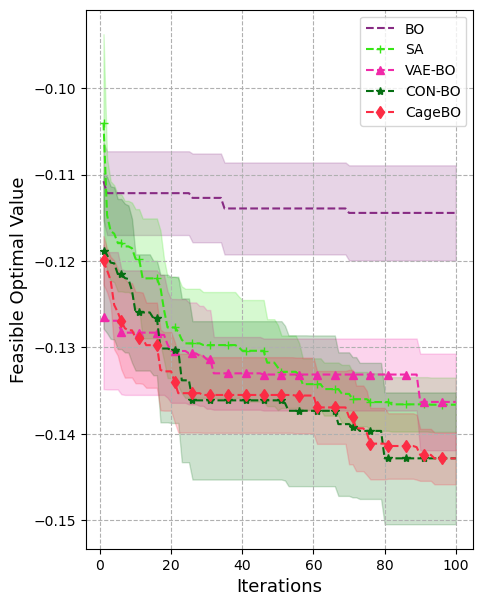

In [29]:
plot_optimal_values(SA_keane_all, VAE_BO_keane_all, CON_BO_keane_all, CageBO_keane_all, NaiveBO_keane_all, 100)

## 2) 30-d Michalewicz Function

In [30]:
from botorch.test_functions.synthetic import Levy, Michalewicz, Powell, Ackley
torch.autograd.set_detect_anomaly(True)

In [31]:
input_dim = 30
latent_dim = 10
condit_dim = 1

In [32]:
michalewicz = Michalewicz(input_dim).to(dtype=dtype, device=device)

In [33]:
vae_michalewicz = VAE(input_dim, hidden_dim, latent_dim).to(device)
cvae_michalewicz = CVAE(input_dim, hidden_dim, latent_dim, condit_dim).to(device)

random_input = torch.rand((num_samples, latent_dim)).to(device)
random_decoded_data = vae_michalewicz.decode(random_input)

min_values, _ = random_decoded_data.min(dim=0)
max_values, _ = random_decoded_data.max(dim=0)

target_min = 0
target_max = np.pi

scaling_factors = (target_max - target_min) / (max_values - min_values)

offset = -((max_values + min_values) / 2.0) * scaling_factors

scaled_data = random_decoded_data * scaling_factors + offset + (target_max + target_min) / 2.0
feasibility = torch.ones(len(scaled_data),1)

### Training

In [34]:
vae_mse_list, vae_kl_list, vae_total_list = train_vae(vae_michalewicz, scaled_data, 1000, batch_size, lr=1e-4, beta=0.1)

Epoch [100/1000], Loss: 4.0968, MSE: 2.0173
Epoch [200/1000], Loss: 3.3433, MSE: 1.2649
Epoch [300/1000], Loss: 3.1955, MSE: 1.1359
Epoch [400/1000], Loss: 3.1248, MSE: 1.0430
Epoch [500/1000], Loss: 3.1178, MSE: 1.0119
Epoch [600/1000], Loss: 3.1122, MSE: 0.9769
Epoch [700/1000], Loss: 3.1118, MSE: 0.9635
Epoch [800/1000], Loss: 3.1255, MSE: 0.9737
Epoch [900/1000], Loss: 3.1763, MSE: 0.9664
Epoch [1000/1000], Loss: 3.1989, MSE: 0.9725


In [35]:
cvae_mse_list, cvae_kl_list, cvae_total_list = train_cvae(cvae_michalewicz, scaled_data, feasibility, 1000, batch_size, lr=1e-4, beta=0.1)

Epoch [100/1000], Loss: 3.2169, MSE: 1.5653
Epoch [200/1000], Loss: 2.5091, MSE: 0.9730
Epoch [300/1000], Loss: 2.2133, MSE: 0.7689
Epoch [400/1000], Loss: 2.0704, MSE: 0.6695
Epoch [500/1000], Loss: 2.0258, MSE: 0.6541
Epoch [600/1000], Loss: 2.0165, MSE: 0.6307
Epoch [700/1000], Loss: 2.0114, MSE: 0.6348
Epoch [800/1000], Loss: 2.0066, MSE: 0.6179
Epoch [900/1000], Loss: 1.9818, MSE: 0.6096
Epoch [1000/1000], Loss: 1.9883, MSE: 0.6152


### Evaluation

In [36]:
n_run = 10

In [37]:
SA_michalewicz_all = []

for _ in range(n_run):
  _, best_energies = simulated_annealing(michalewicz, scaled_data, [-10,10], num_neighbors=10)
  SA_michalewicz_all.append(best_energies)

current energy: tensor([-8.1190], grad_fn=<NegBackward0>)
current energy: tensor([-4.3236], grad_fn=<NegBackward0>)
current energy: tensor([-7.0923], grad_fn=<NegBackward0>)
current energy: tensor([-4.4064], grad_fn=<NegBackward0>)
current energy: tensor([-6.3111], grad_fn=<NegBackward0>)
current energy: tensor([-3.4033], grad_fn=<NegBackward0>)
current energy: tensor([-2.4597], grad_fn=<NegBackward0>)
current energy: tensor([-5.8887], grad_fn=<NegBackward0>)
current energy: tensor([-3.2142], grad_fn=<NegBackward0>)
current energy: tensor([-5.8573], grad_fn=<NegBackward0>)


In [38]:
CageBO_michalewicz_all = []

for _ in range(n_run):
  test_CageBO_michalewicz = CageBO(data=scaled_data,
                        obj_func=michalewicz,
                        autoencoder=cvae_michalewicz,
                        n_initial=n_initial)
  CageBO_michalewicz, _ = test_CageBO_michalewicz.run(l_dim=latent_dim,
                                   n_suggest=n_suggest,
                                   n_iter=100,
                                   lcb=True)
  CageBO_michalewicz_all.append(CageBO_michalewicz)

Initial Best Objective Value: tensor(-5.7972, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7972, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7772, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7772, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.5290, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.5290, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.5290, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.5290, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.8383, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.8383, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.8383, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-10.1188, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-8.1190, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-8.1190, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-8.1190, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.3914, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.3914, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.1279, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.1279, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.1948, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.4584, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.4584, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-7.0672, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-7.0672, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.6901, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.6901, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.8100, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.8100, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.8100, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.8100, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.7287, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7287, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.8989, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.1188, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-8.9847, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-8.9847, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-8.9847, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-8.9847, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-7.2200, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.3472, grad_fn=<UnbindBackward0>)


In [39]:
VAE_BO_michalewicz_all = []

for _ in range(n_run):
  test_BO_michalewicz = LSBO(data=scaled_data,
                      obj_func=michalewicz,
                      autoencoder=vae_michalewicz,
                      n_initial=n_initial)
  VAE_BO_michalewicz, _ = test_BO_michalewicz.run(l_dim=latent_dim,
                                 n_suggest=n_suggest,
                                 n_iter=100,
                                 lcb=True)
  VAE_BO_michalewicz_all.append(VAE_BO_michalewicz)

Initial Best Objective Value: tensor(-10.3160, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-10.3160, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.8684, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.8684, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.8684, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.8684, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.8684, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.5810, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.5810, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.5810, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.5810, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-3.6270, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-3.6270, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-4.1824, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.6136, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.6136, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.5271, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.5271, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.8985, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.8985, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-5.8985, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-5.8985, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-5.8985, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-5.8985, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.7377, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7377, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-7.2449, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.2449, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.3617, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.3617, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.2200, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)


In [40]:
CON_BO_michalewicz_all = []

for i in range(n_run):
  test_LSBO_michalewicz = LSBO(data=scaled_data,
                       obj_func=michalewicz,
                       autoencoder=vae_michalewicz,
                       n_initial=n_initial)

  CON_BO_michalewicz, _ = test_LSBO_michalewicz.run(l_dim=latent_dim,
                                      n_suggest=n_suggest,
                                      n_iter=100,
                                      lcb=False)
  CON_BO_michalewicz_all.append(CON_BO_michalewicz)

Initial Best Objective Value: tensor(-5.7448, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7448, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7418, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7418, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7418, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7418, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7418, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.5787, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.5787, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.5787, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.5787, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.1311, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.1311, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.2292, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.6117, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.6117, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-5.6117, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.1901, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.1901, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.1901, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.1901, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.1565, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.1565, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-4.1400, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-4.1400, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.0280, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.8448, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.8448, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.8448, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.9248, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.9248, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.9248, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.9248, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-4.6938, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-4.6938, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.0280, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.0280, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.0317, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.7347, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7347, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-5.9001, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.3914, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.8003, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.1085, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.1085, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.5810, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.5810, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-6.6959, grad_fn=<UnbindBackward0>)


In [41]:
NaiveBO_michalewicz_all = []

for _ in range(n_run):
  test_NaiveBO_michalewicz = naive_BO(data=scaled_data,
                        obj_func=michalewicz,
                        n_initial=n_initial)
  NaiveBO_michalewicz, _ = test_NaiveBO_michalewicz.run(n_suggest=n_suggest,
                                   n_iter=100,
                                   lcb=True)
  NaiveBO_michalewicz_all.append(NaiveBO_michalewicz)

Initial Best Objective Value: tensor(-6.8407, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.8407, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.8638, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.8638, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.8638, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-9.0154, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-7.8685, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.8685, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-7.5685, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-7.5685, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.2656, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.2656, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-6.2656, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-6.8305, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-6.8305, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-4.7777, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-4.7777, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.7347, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.7347, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-4.1587, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-4.1587, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.0700, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.0700, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-8.8289, grad_fn=<UnbindBackward0>)
Initial Best Objective Value: tensor(-5.8944, grad_fn=<UnbindBackward0>)


  0%|          | 0/100 [00:00<?, ?it/s]

iter 0  best fX: tensor(-5.8944, grad_fn=<UnbindBackward0>)
iter 10  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 20  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 30  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 40  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 50  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 60  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 70  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 80  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)
iter 90  best fX: tensor(-7.7419, grad_fn=<UnbindBackward0>)


In [42]:
colors = ["#056e12", "#f029a8", "#fc2c44", "#872b83", "#36e515"]

def plot_optimal_values(SA_path, VAE_BO_path, CON_BO_path, CageBO_path, NaiveBO_path, max_iter):
    fig, ax = plt.subplots(figsize=(5,7))

    ax.set_ylabel('Feasible Optimal Value', fontsize=13)
    ax.set_xlabel('Iterations', fontsize=13)

    iterations = np.arange(1, max_iter+1)

    # Unpack lists
    SA_path = torch.stack([torch.stack(inner) for inner in SA_path])
    CageBO_path = torch.stack([torch.stack(inner) for inner in CageBO_path])
    VAE_BO_path = torch.stack([torch.stack(inner) for inner in VAE_BO_path])
    CON_BO_path = torch.stack([torch.stack(inner) for inner in CON_BO_path])
    NaiveBO_path = torch.stack([torch.stack(inner) for inner in NaiveBO_path])

    SA_path = SA_path[:, :max_iter]
    CageBO_path = CageBO_path[:, :max_iter]
    VAE_BO_path = VAE_BO_path[:, :max_iter]
    CON_BO_path = CON_BO_path[:, :max_iter]
    NaiveBO_path = NaiveBO_path[:, :max_iter]

    # Calculate means
    SA_mean = torch.mean(SA_path, axis=0)
    CageBO_mean = torch.mean(CageBO_path, dim=0)
    VAE_BO_mean = torch.mean(VAE_BO_path, dim=0)
    CON_BO_mean = torch.mean(CON_BO_path, dim=0)
    NaiveBO_mean = torch.mean(NaiveBO_path, dim=0)

    # Calculate 95% confidence intervals for means
    confidence_interval = 1.96

    SA_std_err = torch.std(SA_path, dim=0, unbiased=True) / np.sqrt(len(SA_path))
    CageBO_std_err = torch.std(CageBO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(CageBO_path), dtype=torch.float32))
    VAE_BO_std_err = torch.std(VAE_BO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(VAE_BO_path), dtype=torch.float32))
    CON_BO_std_err = torch.std(CON_BO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(CON_BO_path), dtype=torch.float32))
    NaiveBO_std_err = torch.std(NaiveBO_path, dim=0, unbiased=True) / torch.sqrt(torch.tensor(len(NaiveBO_path), dtype=torch.float32))

    SA_ci = confidence_interval * SA_std_err
    CageBO_ci = confidence_interval * CageBO_std_err
    VAE_BO_ci = confidence_interval * VAE_BO_std_err
    CON_BO_ci = confidence_interval * CON_BO_std_err
    NaiveBO_ci = confidence_interval * NaiveBO_std_err

    # Plot means with confidence intervals

    ax.plot(iterations, NaiveBO_mean.cpu().detach().numpy(), linestyle='--', markevery=5, c=colors[3], label='BO')
    ax.fill_between(iterations, NaiveBO_mean.cpu().detach().numpy() - NaiveBO_ci.cpu().detach().numpy(), NaiveBO_mean.cpu().detach().numpy() + NaiveBO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[3])

    ax.plot(iterations, SA_mean.cpu().detach().numpy(), linestyle='--', marker='+', markevery=5, c=colors[4], label='SA')
    ax.fill_between(iterations, SA_mean.cpu().detach().numpy() - SA_ci.cpu().detach().numpy(), SA_mean.cpu().detach().numpy() + SA_ci.cpu().detach().numpy(), alpha=0.2, color=colors[4])

    ax.plot(iterations, VAE_BO_mean.cpu().detach().numpy(), linestyle='--', marker='^', markevery=5, c=colors[1], label='VAE-BO')
    ax.fill_between(iterations, VAE_BO_mean.cpu().detach().numpy() - VAE_BO_ci.cpu().detach().numpy(), VAE_BO_mean.cpu().detach().numpy() + VAE_BO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[1])

    ax.plot(iterations, CON_BO_mean.cpu().detach().numpy(), linestyle='--', marker='*', markevery=5, c=colors[0], label='CON-BO')
    ax.fill_between(iterations, CON_BO_mean.cpu().detach().numpy() - CON_BO_ci.cpu().detach().numpy(), CON_BO_mean.cpu().detach().numpy() + CON_BO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[0])
    
    ax.plot(iterations, CageBO_mean.cpu().detach().numpy(), linestyle='--', marker='d', markevery=5, c=colors[2], label='CageBO')
    ax.fill_between(iterations, CageBO_mean.cpu().detach().numpy() - CageBO_ci.cpu().detach().numpy(), CageBO_mean.cpu().detach().numpy() + CageBO_ci.cpu().detach().numpy(), alpha=0.2, color=colors[2])

    ax.legend()
    plt.grid(axis='both', ls='--')
    # plt.savefig("plots/Michalewicz_all.png", dpi=300, bbox_inches='tight')
    plt.show()


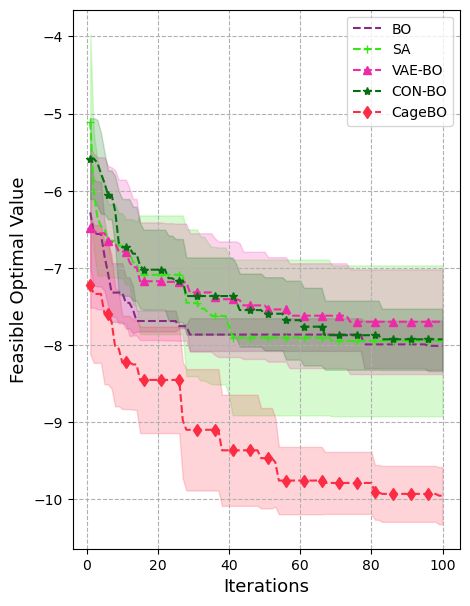

In [43]:
plot_optimal_values(SA_michalewicz_all, VAE_BO_michalewicz_all, CON_BO_michalewicz_all, CageBO_michalewicz_all, NaiveBO_michalewicz_all, 100)